<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/benchmarking/benchmark_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Benchmarking different Neural Net architectures on the weather time series dataset recorded by the Max Plank Institute for Biogeochemistry**

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python. The code is also available at https://www.tensorflow.org/tutorials/structured_data/time_series , with the exception of the Neural Net architectures. 


SETUP

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

We will deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time.

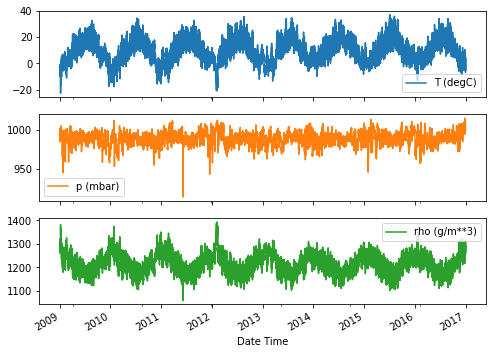

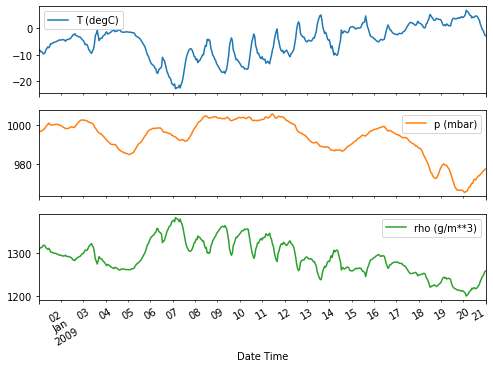

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

***INSPECT AND CLEANUP***

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


**Wind velocity**

One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

***FEATURE ENGINEERING***

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

**Wind**

The last column of the data, wd (deg), gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

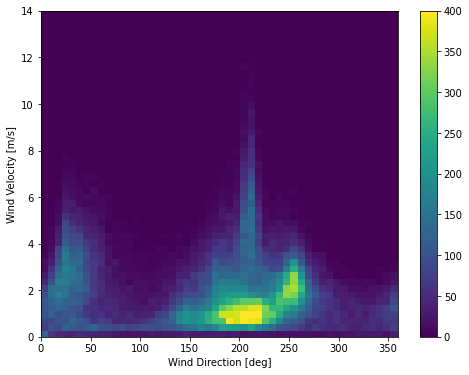

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

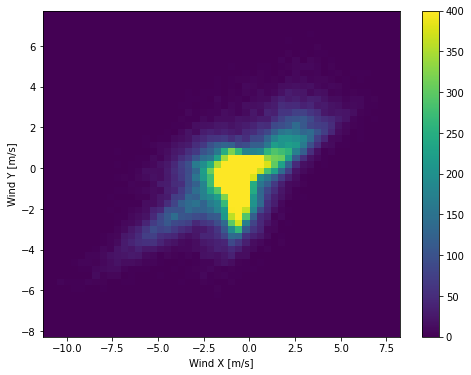

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

**Time**

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

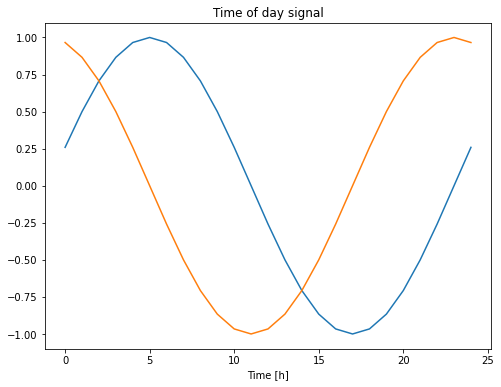

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case we knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an fft. To check our assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

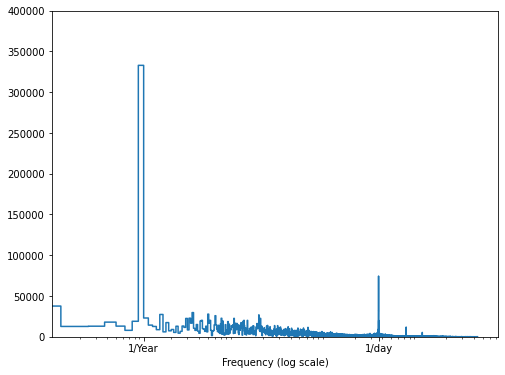

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

***SPLIT THE DATA***

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

-It ensures that chopping the data into windows of consecutive samples is still possible.

-It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

**Normalize the data**

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the -9999 wind velocity value.

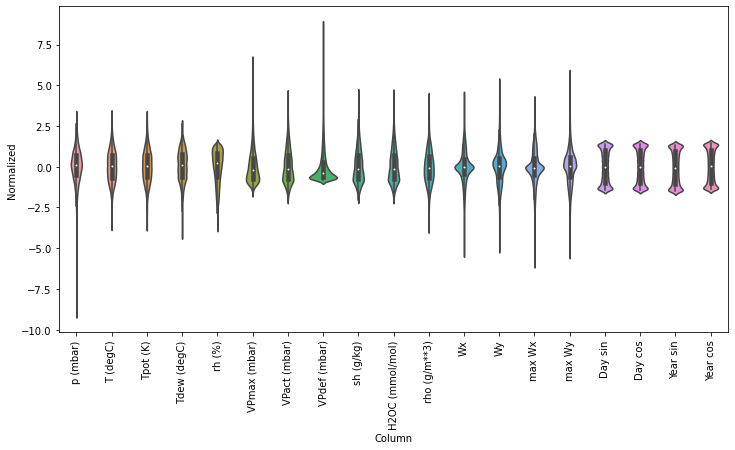

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

***WINDOWING***

The rest of this section defines a WindowGenerator class. This class can:

Handle the indexes and offsets as shown in the diagrams above.
Split windows of features into a (features, labels) pairs.
Plot the content of the resulting windows.
Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

**1.Indexes and offsets**

Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to tf.data.Datasets of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the windowed dataset with only one time-shift:

In [ ]:
w2 = WindowGenerator(input_width=64, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 65
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label indices: [64]
Label column name(s): ['T (degC)']

**2. Split**

Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the WindowGenerator was initialized with label_columns=['T (degC)']. Initially this tutorial will build models that predict single output labels.

**3. Plot**

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

All shapes are: (batch, time, features)
Window shape: (3, 65, 19)
Inputs shape: (3, 64, 19)
labels shape: (3, 1, 1)


This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

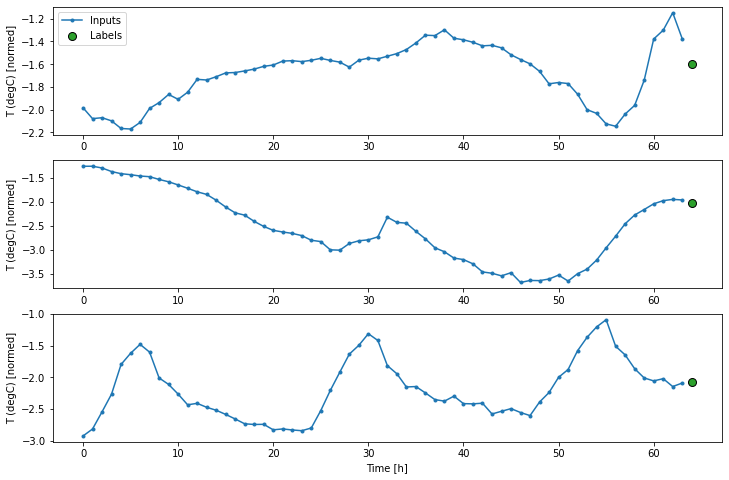

In [ ]:
w2.plot()

You can plot the other columns, but the example window w2 configuration only has labels for the T (degC) column.

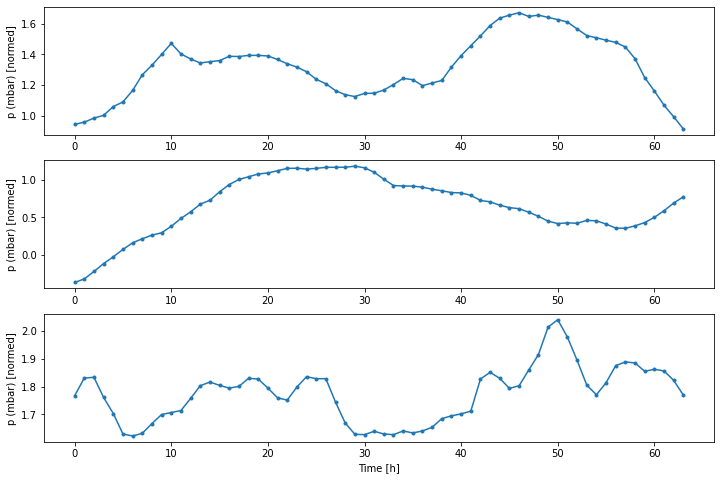

In [ ]:
w2.plot(plot_col='p (mbar)')

**4. Create tf.data.Datasets**

Finally this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation and test data. Add properties for accessing them as tf.data.Datasets using the above make_dataset method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the WindowGenerator object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The Dataset.element_spec property tells you the structure, dtypes and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 64, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 64, 19)
Labels shape (batch, time, features): (32, 1, 1)


***SINGLE STEP MODEL***

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the T (degC) value 1h into the future.

Configure a WindowGenerator object to produce these single-step (input, label) pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The window object creates tf.data.Datasets from the training, validation, and test sets, allowing you to easily iterate over batches of data.

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


***1. LINEAR MODEL***

The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step.

A layers.Dense with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units), it is applied independently to every item across the batch and time axes.

In [ ]:
linear = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.Dense(3)])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 19)
Output shape: (32, 3)


As we train many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 20

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  mcp = ModelCheckpoint('/content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5', monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)  
  


  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, mcp])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1523/1534 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0836
Epoch 00001: val_loss improved from inf to 0.00925, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0189 - mean_absolute_error: 0.0836 - val_loss: 0.0092 - val_mean_absolute_error: 0.0721
Epoch 2/20
1524/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725
Epoch 00002: val_loss did not improve from 0.00925
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0725 - val_loss: 0.0093 - val_mean_absolute_error: 0.0717
Epoch 3/20
1525/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0729
Epoch 00003: val_loss did not improve from 0.00925
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0098 - mean_absolute_error: 0.0729 - val_loss: 0.0098 

The linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The time axis acts like another batch axis. There are no interactions between the precictions at each time step.

***2. LINEAR MODEL WITH ADDED NONLINEARITY***

The simplest way to add nonlinearity to the previously presented linear model is to supplement the Dense layer with a nonlinear activation function. There are three widely used nonlinear activations (not counting functions which are combinations of linear functions such as RELU), the sigmoid, tanh and softmax functions. The softmax activation is used for classification as it converts a real vector to a vector of categorical probabilities. The application of the sigmoid function yield better results for this problem than the tanh function, however the outputs are restricted between 0 and 1. To compensate for the asymptotes, an additional linear node is required.

From this point on, the code is similar to the previously detailed linear model

In [ ]:
nonlinear = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='sigmoid'),
            tf.keras.layers.Dense(3)])

In [ ]:
history = compile_and_fit(nonlinear, single_step_window)

val_performance['Nonlinear'] = nonlinear.evaluate(single_step_window.val)
performance['Nonlinear'] = nonlinear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1520/1534 [============================>.] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.1138
Epoch 00001: val_loss improved from inf to 0.00985, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0406 - mean_absolute_error: 0.1135 - val_loss: 0.0099 - val_mean_absolute_error: 0.0739
Epoch 2/20
1527/1534 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734
Epoch 00002: val_loss improved from 0.00985 to 0.00905, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0734 - val_loss: 0.0091 - val_mean_absolute_error: 0.0709
Epoch 3/20
1527/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707
Epoch 00003: val_loss did not improve from 0.00905
1534/1534 [=================

***3. DEEP NEURAL NET WITH MIXED LINEAR AND NONLINEAR PROCESSING***

Deep neural nets allow complex inormation transformations through several steps, which in this case is represented by stacks of subsequent linear (Dense) and nonliear layers.

From this point on, the code is similar to the previously detailed linear model

Notice that the number of units is 64 instead of 1 as for the previous examples. This results in dense, fully connected layers with orders of magnitude more trainable parameters.

In [ ]:
dnn = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(512, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(1024, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(1024, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(512, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(3)
            ])



history = compile_and_fit(dnn, single_step_window)
dnn.summary()
val_performance['DNN'] = dnn.evaluate(single_step_window.val)
performance['DNN'] = dnn.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1524/1534 [============================>.] - ETA: 0s - loss: 0.1109 - mean_absolute_error: 0.2450
Epoch 00001: val_loss improved from inf to 0.04330, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 10s 6ms/step - loss: 0.1106 - mean_absolute_error: 0.2446 - val_loss: 0.0433 - val_mean_absolute_error: 0.1681
Epoch 2/20
1526/1534 [============================>.] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.1646
Epoch 00002: val_loss improved from 0.04330 to 0.02314, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0468 - mean_absolute_error: 0.1646 - val_loss: 0.0231 - val_mean_absolute_error: 0.1157
Epoch 3/20
1525/1534 [============================>.] - ETA: 0s - loss: 0.0469 - mean_absolute_error: 0.1643
Epoch 00003: val_loss did not improve from 0.02314
1534/1534 [===============

***4. WAVENET***

In a 2016 paper,13 Aaron van den Oord and other DeepMind researchers introduced an architecture called WaveNet. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently. -- Aurélien Géron

In [ ]:
from keras import initializers
from keras.layers import Dense, Dropout, Activation, Flatten, Input, TimeDistributed, Reshape, Permute, Conv1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Nadam

num_segments=1
num_syn_types=2
filter_sizes_per_layer=[20] * 3
num_filters_per_layer=[8] * 3
activation_function_per_layer=['relu'] * 3
l2_regularization_per_layer=[1e-8] * 3
strides_per_layer=[1] * 3
dilation_rates_per_layer=[1] * 3
initializer_per_layer=[0.002] * 3
from keras.regularizers import l1,l2,l1_l2

def create_temporaly_convolutional_model(TIME_STEPS, num_segments, num_syn_types, filter_sizes_per_layer,
                                                                                            num_filters_per_layer,
                                                                                            activation_function_per_layer,
                                                                                            l2_regularization_per_layer,
                                                                                            strides_per_layer,
                                                                                            dilation_rates_per_layer,
                                                                                            initializer_per_layer):
    
    # define input and flatten it
    binary_input_mat = Input(shape=(1, 19), name='input_layer')

    for k in range(len(filter_sizes_per_layer)):
        num_filters   = num_filters_per_layer[k]
        filter_size   = filter_sizes_per_layer[k]
        activation    = activation_function_per_layer[k]
        l2_reg        = l2_regularization_per_layer[k]
        stride        = strides_per_layer[k]
        dilation_rate = dilation_rates_per_layer[k]
        initializer   = initializer_per_layer[k]
        
            
        if not isinstance(initializer, str):
            initializer = initializers.TruncatedNormal(stddev=initializer)
        
        if k == 0:
            x = Conv1D(num_filters, filter_size, activation=activation, kernel_initializer=initializer, kernel_regularizer=l2(l2_reg),
                       strides=stride, dilation_rate=dilation_rate, padding='causal', name='layer_%d' %(k + 1))(binary_input_mat)
        else:
            x = Conv1D(num_filters, filter_size, activation=activation, kernel_initializer=initializer, kernel_regularizer=l2(l2_reg),
                       strides=stride, dilation_rate=dilation_rate, padding='causal', name='layer_%d' %(k + 1))(x)
        x = BatchNormalization(name='layer_%d_BN' %(k + 1))(x)
        

    output_soma_init  = initializers.TruncatedNormal(stddev=0.03)
    intermediate = Conv1D(1, 1, activation='linear' , kernel_initializer=output_soma_init, kernel_regularizer=l2(1e-8), padding='causal', name='somatic')(x)
    flat = Flatten()(intermediate)
    output_soma_voltage_pred = Dense(1)(flat)

    temporaly_convolutional_network_model = Model(inputs=binary_input_mat, outputs=output_soma_voltage_pred)

    optimizer_to_use = Nadam(lr=0.0001)
    temporaly_convolutional_network_model.compile(optimizer=optimizer_to_use,
                                                  loss='mse')
    temporaly_convolutional_network_model.summary()
    
    return temporaly_convolutional_network_model

In [ ]:

wavenet = create_temporaly_convolutional_model(64, 1, num_syn_types,
                                                         filter_sizes_per_layer, num_filters_per_layer,
                                                         activation_function_per_layer, l2_regularization_per_layer,
                                                         strides_per_layer, dilation_rates_per_layer, initializer_per_layer)

    
    
history = compile_and_fit(wavenet, single_step_window)
val_performance['Wavenet'] = wavenet.evaluate(single_step_window.val)
performance['Wavenet'] = wavenet.evaluate(single_step_window.test, verbose=0)




Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 19)]           0         
_________________________________________________________________
layer_1 (Conv1D)             (None, 1, 8)              3048      
_________________________________________________________________
layer_1_BN (BatchNormalizati (None, 1, 8)              32        
_________________________________________________________________
layer_2 (Conv1D)             (None, 1, 8)              1288      
_________________________________________________________________
layer_2_BN (BatchNormalizati (None, 1, 8)              32        
_________________________________________________________________
layer_3 (Conv1D)             (None, 1, 8)              1288      
_________________________________________________________________
layer_3_BN (BatchNormalizati (None, 1, 8)             

***5. CNN-LSTM***

Long short-term memory recurrent neural networks are capable of automatically learning features from sequence data and support multiple-variate data. The recurrent LSTM layer processes temporal information arriving from two different sources: the present information arriving from lower layers and the processed past information arriving from the recurrent layer itself. To augment the data-processing capabilities of this layer, convolutional layers can be used for learning short term patterns (the temporal ordering of the data can be preserved through the usage of causal padding) as lower layers.  

In [ ]:
cnn_lstm = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, 1, activation='relu', kernel_initializer="he_uniform", padding="causal"),
        tf.keras.layers.Conv1D(100, 5, activation='relu', kernel_initializer="he_uniform", padding="causal"),
        tf.keras.layers.Conv1D(50, 1, activation='tanh', kernel_initializer='glorot_uniform', padding="causal"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.RepeatVector(1),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_uniform")),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dropout(rate=0.15),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dropout(rate=0.15),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dropout(rate=0.15),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dropout(rate=0.15),
        tf.keras.layers.Dense(1)])



history = compile_and_fit(cnn_lstm, single_step_window)
cnn_lstm.summary()
val_performance['CNN_LSTM'] = cnn_lstm.evaluate(single_step_window.val)
performance['CNN_LSTM'] = cnn_lstm.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.1356
Epoch 00001: val_loss improved from inf to 0.02997, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 16s 11ms/step - loss: 0.0359 - mean_absolute_error: 0.1356 - val_loss: 0.0300 - val_mean_absolute_error: 0.1433
Epoch 2/20
1529/1534 [============================>.] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.1100
Epoch 00002: val_loss improved from 0.02997 to 0.02423, saving model to /content/drive/My Drive/DNN/Ball_improved/Benchmark_on_weather/dummy.h5
1534/1534 [==============================] - 16s 10ms/step - loss: 0.0220 - mean_absolute_error: 0.1100 - val_loss: 0.0242 - val_mean_absolute_error: 0.1226
Epoch 3/20
1528/1534 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0992
Epoch 00003: val_loss improved from 0.02423 to 0.00961, saving model to /co

***PERFORMANCE***

With this dataset typically each of the models does slightly better than the one before it.

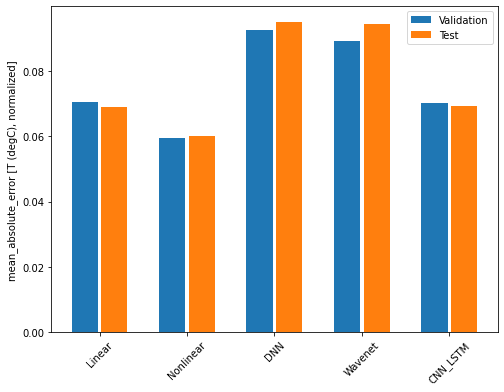

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = cnn_lstm.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
val_performance.values()


dict_values([[0.008937636390328407, 0.07028112560510635], [0.006776686757802963, 0.059419285506010056], [0.016564717516303062, 0.09231763333082199], [0.01332618948072195, 0.08908339589834213], [0.008692856878042221, 0.07005798071622849]])

In [ ]:
performance.values()

dict_values([[0.008754887618124485, 0.0687599927186966], [0.0067503987811505795, 0.05989738181233406], [0.016530269756913185, 0.09491129964590073], [0.01480141468346119, 0.09417582303285599], [0.008278901688754559, 0.06925366073846817]])